<a href="https://colab.research.google.com/github/davemcg/scEiaD/blob/colab/colab/scVI_projection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Querying scEiaD with scVI
The Yosef Lab folks use the "reference" and "query" terms. In this case, reference is the scVI model built for scEiaD. Query is outside data. Your data. If you query (or project) your data with the scVI/scEiaD model, then you will get a set of latent dimensions that you use to make a UMAP visualization that will closely approximate the one hosted at https://plae.nei.nih.gov

In the future we will also share our xgboost model so you can label retina cell types data with our highly trained xgboost-based machine learning model. 

# Overview
1. Install scvi and kallisto-bustools
2. Download our kallisto index
3. Download our scVI model
4. Quantify SRA dataset X with kallisto-bustools
5. Querying SRA dataset with scVI




# Install scvi and kallisto-bustools

In [1]:
import sys
import re
#if True, will install via pypi, else will install from source
stable = True
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and stable:
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and not stable:
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@master#egg=scvi-tools[tutorials]

!pip install kb-python


     |████████████████████████████████| 153kB 5.7MB/s 
     |████████████████████████████████| 184kB 16.8MB/s 
     |████████████████████████████████| 122kB 18.0MB/s 
     |████████████████████████████████| 245kB 16.3MB/s 
     |████████████████████████████████| 8.7MB 10.9MB/s 
     |████████████████████████████████| 7.7MB 40.1MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 2.4MB 38.9MB/s 
     |████████████████████████████████| 3.2MB 36.4MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
     |████████████████████████████████| 112kB 40.1MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
     |████████████████████████████████| 71kB 8.5MB/s 
     |████████████████████████████████| 59.1MB 47kB/s 
     |████████████████████████████████| 13.2MB 252kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


# Optional! Download our kallisto index
As our example set is mouse, we use the mouse Gencode vM25 transcript reference.

(Our human kallisto idx and tr2g are here):
```
https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/gencode.v35.transcripts.idx
https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/v35.tr2g.tsv
```

If you want to skip the kallisto quant (~15 minutes) then you can skip a few chunks below to where we load the h5ad object for the query (non scEiaD) data.

In [5]:
%%time
!wget -O idx.idx https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/gencode.vM25.transcripts.idx
!wget -O t2g.txt https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/vM25.tr2g.tsv

--2021-01-05 15:00:20--  https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/gencode.vM25.transcripts.idx
Resolving hpc.nih.gov (hpc.nih.gov)... 128.231.2.150, 2607:f220:418:4801::2:96
Connecting to hpc.nih.gov (hpc.nih.gov)|128.231.2.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2662625893 (2.5G) [application/octet-stream]
Saving to: ‘idx.idx’

idx.idx             100%[===================>]   2.48G  15.9MB/s    in 2m 44s  

2021-01-05 15:03:05 (15.5 MB/s) - ‘idx.idx’ saved [2662625893/2662625893]

--2021-01-05 15:03:05--  https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/vM25.tr2g.tsv
Resolving hpc.nih.gov (hpc.nih.gov)... 128.231.2.150, 2607:f220:418:4801::2:96
Connecting to hpc.nih.gov (hpc.nih.gov)|128.231.2.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23498117 (22M) [application/octet-stream]
Saving to: ‘t2g.txt’

t2g.txt             100%[===================>]  22.41M  8.72MB/s    in 2.6s    

2021-01-05 15:03:08 (8.72 MB/s) - ‘

# Optional! Quantify with kbtools (Kallisto - Bustools wrapper) in one easy step.

kallisto can stream the fastq from the url we provide. Going into the vagaries of turning a SRA deposit into a non-borked pair of fastq is beyond the scope of this document. 

If you have your own 10X bam file, then 10X provides a very nice and simple tool to turn it into fastq file here: https://github.com/10XGenomics/bamtofastq

To reduce run-time we have taken the first ten million reads from the this fastq pair.

This will take ~10 minute.

If you want to skip the kallisto quant then you can skip to a few chunks below to where we load the h5ad object for the query (non scEiaD) data.

 

In [9]:
%%time
!kb count --overwrite --h5ad -i idx.idx -g t2g.txt -x 10xv2 -o output --filter bustools -t 2 \
  https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/SRR12130653_1.head.fastq.gz \
  https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/SRR12130653_2.head.fastq.gz

[2021-01-05 15:52:03,790]    INFO Piping https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/SRR12130653_1.head.fastq.gz to output/tmp/SRR12130653_1.head.fastq.gz
[2021-01-05 15:52:03,792]    INFO Piping https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/SRR12130653_2.head.fastq.gz to output/tmp/SRR12130653_2.head.fastq.gz
[2021-01-05 15:52:03,793]    INFO Using index idx.idx to generate BUS file to output from
[2021-01-05 15:52:03,793]    INFO         output/tmp/SRR12130653_1.head.fastq.gz
[2021-01-05 15:52:03,793]    INFO         output/tmp/SRR12130653_2.head.fastq.gz
[2021-01-05 15:52:41,943]    INFO Sorting BUS file output/output.bus to output/tmp/output.s.bus
[2021-01-05 15:52:44,973]    INFO Whitelist not provided
[2021-01-05 15:52:44,973]    INFO Copying pre-packaged 10XV2 whitelist to output
[2021-01-05 15:52:45,093]    INFO Inspecting BUS file output/tmp/output.s.bus
[2021-01-05 15:52:46,578]    INFO Correcting BUS records in output/tmp/output.s.bus to output/tmp/output.s.c.bus with whitel

# Download scEiaD anndata object and scVI model
We've provided a cut-down scEiaD with ~50,000 cells so this tutorial works in colab (12GB max memory usage here!)

In [10]:
import scvi
import scanpy as sc
import pandas as pd 
#sc.set_figure_params(figsize=(8, 8))

!wget -O scEiaD.h5ad https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/scEiaD_subsample.h5ad
adata_scEiaD = sc.read_h5ad('scEiaD.h5ad')
adata_scEiaD

# Download the scEiaD scVI model and untar
!wget -O 2021_01_03__scVI_scEiaD.tgz https://hpc.nih.gov/~mcgaugheyd/scEiaD/2021_01_03/2021_01_03__scVI_scEiaD.tgz
!tar -xzf 2021_01_03__scVI_scEiaD.tgz
# Set scVI model path
scVI_model_dir_path = 'scVIprojectionSO_scEiaD_model/n_features-5000__transform-counts__partition-universe__covariate-batch__method-scVIprojectionSO__dims-8'
# Read in HVG genes used in scVI model
var_names = pd.read_csv(scVI_model_dir_path + '/var_names.csv', header = None)

--2021-01-05 15:53:21--  https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/scEiaD_subsample.h5ad
Resolving hpc.nih.gov (hpc.nih.gov)... 128.231.2.150, 2607:f220:418:4801::2:96
Connecting to hpc.nih.gov (hpc.nih.gov)|128.231.2.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338256542 (323M) [application/octet-stream]
Saving to: ‘scEiaD.h5ad’

scEiaD.h5ad         100%[===================>] 322.59M  16.6MB/s    in 21s     

2021-01-05 15:53:44 (15.1 MB/s) - ‘scEiaD.h5ad’ saved [338256542/338256542]

--2021-01-05 15:53:48--  https://hpc.nih.gov/~mcgaugheyd/scEiaD/2021_01_03/2021_01_03__scVI_scEiaD.tgz
Resolving hpc.nih.gov (hpc.nih.gov)... 128.231.2.150, 2607:f220:418:4801::2:96
Connecting to hpc.nih.gov (hpc.nih.gov)|128.231.2.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12854476 (12M) [application/octet-stream]
Saving to: ‘2021_01_03__scVI_scEiaD.tgz’

2021_01_03__scVI_sc 100%[===================>]  12.26M  6.14MB/s    in 2.0s    

# Load query h5ad
If you ran kallisto quant above, then this is where you load the data. If you are impatient, then you can just load the h5ad output that we pre-ran for you.



In [11]:
# uncomment the line below if you want to just use our precomputed h5ad object
#!wget -O output/counts_filtered/adata.h5ad https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/adata.h5ad

adata_query = sc.read_h5ad('output/counts_filtered/adata.h5ad')
adata_query

AnnData object with n_obs × n_vars = 52 × 55401
    var: 'gene_name'

# Some futzing required

This mouse data was *not* used in the original scVI model. 

The scVI model was built on human data, with human ensembl IDs (e.g. ENSG00000105392).

So we have to convert our ensembl *mouse* IDs to *human*. 

We provide a conversion file:
```
https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/ensembl_biomart_human2mouse_macaque.tsv
```



In [12]:
import pandas as pd
conversion_table = pd.read_csv('https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/ensembl_biomart_human2mouse_macaque.tsv', sep = '\t')
conversion_table

Gene stable ID Gene stable ID version  ... Macaque gene name Mouse gene name
0      ENSG00000210049      ENSG00000210049.1  ...               NaN             NaN
1      ENSG00000211459      ENSG00000211459.2  ...               NaN             NaN
2      ENSG00000210077      ENSG00000210077.1  ...               NaN             NaN
3      ENSG00000210082      ENSG00000210082.2  ...               NaN             NaN
4      ENSG00000209082      ENSG00000209082.1  ...               NaN             NaN
...                ...                    ...  ...               ...             ...
77058  ENSG00000284933      ENSG00000284933.2  ...               NaN             NaN
77059  ENSG00000285328      ENSG00000285328.2  ...               NaN             NaN
77060  ENSG00000288119      ENSG00000288119.1  ...               NaN             NaN
77061  ENSG00000285363      ENSG00000285363.1  ...               NaN             NaN
77062  ENSG00000285114      ENSG00000285114.2  ...               NaN             NaN

[77063 rows x 7 columns]

## VINAY FIX HERE?!
The code below removes the ".\d+" ending. The gene names are stored in a pandas obj at `adata_query.var_names`. So you have to swap those out for the human ones with some kind of join operation?

In [14]:
adata_query.var_names = [re.sub('\.\d+','', x) for x in adata_query.var_names]
adata_query.var['gene_name'] = [re.sub('\.\d+','', x) for x in adata_query.var_names]
adata_query.var_names

Index(['ENSMUSG00000102693', 'ENSMUSG00000064842', 'ENSMUSG00000051951',
       'ENSMUSG00000102851', 'ENSMUSG00000103377', 'ENSMUSG00000104017',
       'ENSMUSG00000103025', 'ENSMUSG00000089699', 'ENSMUSG00000103201',
       'ENSMUSG00000103147',
       ...
       'ENSMUSG00000064363', 'ENSMUSG00000064364', 'ENSMUSG00000064365',
       'ENSMUSG00000064366', 'ENSMUSG00000064367', 'ENSMUSG00000064368',
       'ENSMUSG00000064369', 'ENSMUSG00000064370', 'ENSMUSG00000064371',
       'ENSMUSG00000064372'],
      dtype='object', length=55401)

In [69]:
adata_query.obs['scEiaD_batch'] = 'SRR12130653'
adata_query.obs['query'] = 'SRR12130653'
adata_query.obs['CellType_predict'] = 'SRR12130653'
adata_scEiaD.obs['scEiaD_batch'] = adata_scEiaD.obs['batch']
adata_scEiaD.obs['query'] = 'scEiaD'
adata_full = adata_query.concatenate(adata_scEiaD)
adata_full.obs['batch'] = adata_full.obs['scEiaD_batch']
scvi.data.setup_anndata(adata_full, batch_key="batch")

INFO     Using batches from adata.obs["batch"]                                  
INFO     No label_key inputted, assuming all cells have same label              
INFO     Using data from adata.X                                                
INFO     Computing library size prior per batch                                 
INFO     Successfully registered anndata object containing 55643 cells, 14942   
         vars, 88 batches, 1 labels, and 0 proteins. Also registered 0 extra    
         categorical covariates and 0 extra continuous covariates.              
INFO     Please do not further modify adata until model is trained.             


In [71]:
adata_full_HVG = adata_full[:,adata_full.var['gene_name-0'].isin(var_names[0])]
adata_full_HVG = adata_full[:, var_names[0]]
#scvi.data.setup_anndata(adata_full_HVG, batch_key="batch")

KeyError: ignored

In [ ]:
adata_full

In [ ]:
vae_full = scvi.model.SCVI.load_query_data(
    adata_full_HVG, 
    scVI_model_dir_path,
    use_cuda = True,
)

In [37]:
vae_full.train(n_epochs = 5, weight_decay=0.0)

INFO     Training for 5 epochs                                                  
INFO     KL warmup phase exceeds overall training phaseIf your applications rely
         on the posterior quality, consider training for more epochs or reducing
         the kl warmup.                                                         
INFO     KL warmup for 400 epochs                                               
Training...:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/scvi/core/distributions/_negative_binomial.py:434: UserWarning: The value argument must be within the support of the distribution
  UserWarning,


Training...: 100%|██████████| 5/5 [00:18<00:00,  3.64s/it]
INFO     Training is still in warming up phase. If your applications rely on the
         posterior quality, consider training for more epochs or reducing the kl
         warmup.                                                                
INFO     Training time:  18 s. / 5 epochs                                       


In [53]:
adata_full.obsm['X_scvi'] = vae_full.get_latent_representation()
sc.pp.neighbors(adata_full, n_neighbors=10, use_rep = 'X_scvi')
sc.tl.umap(adata_full, min_dist=0.2)
sc.tl.leiden(adata_full)

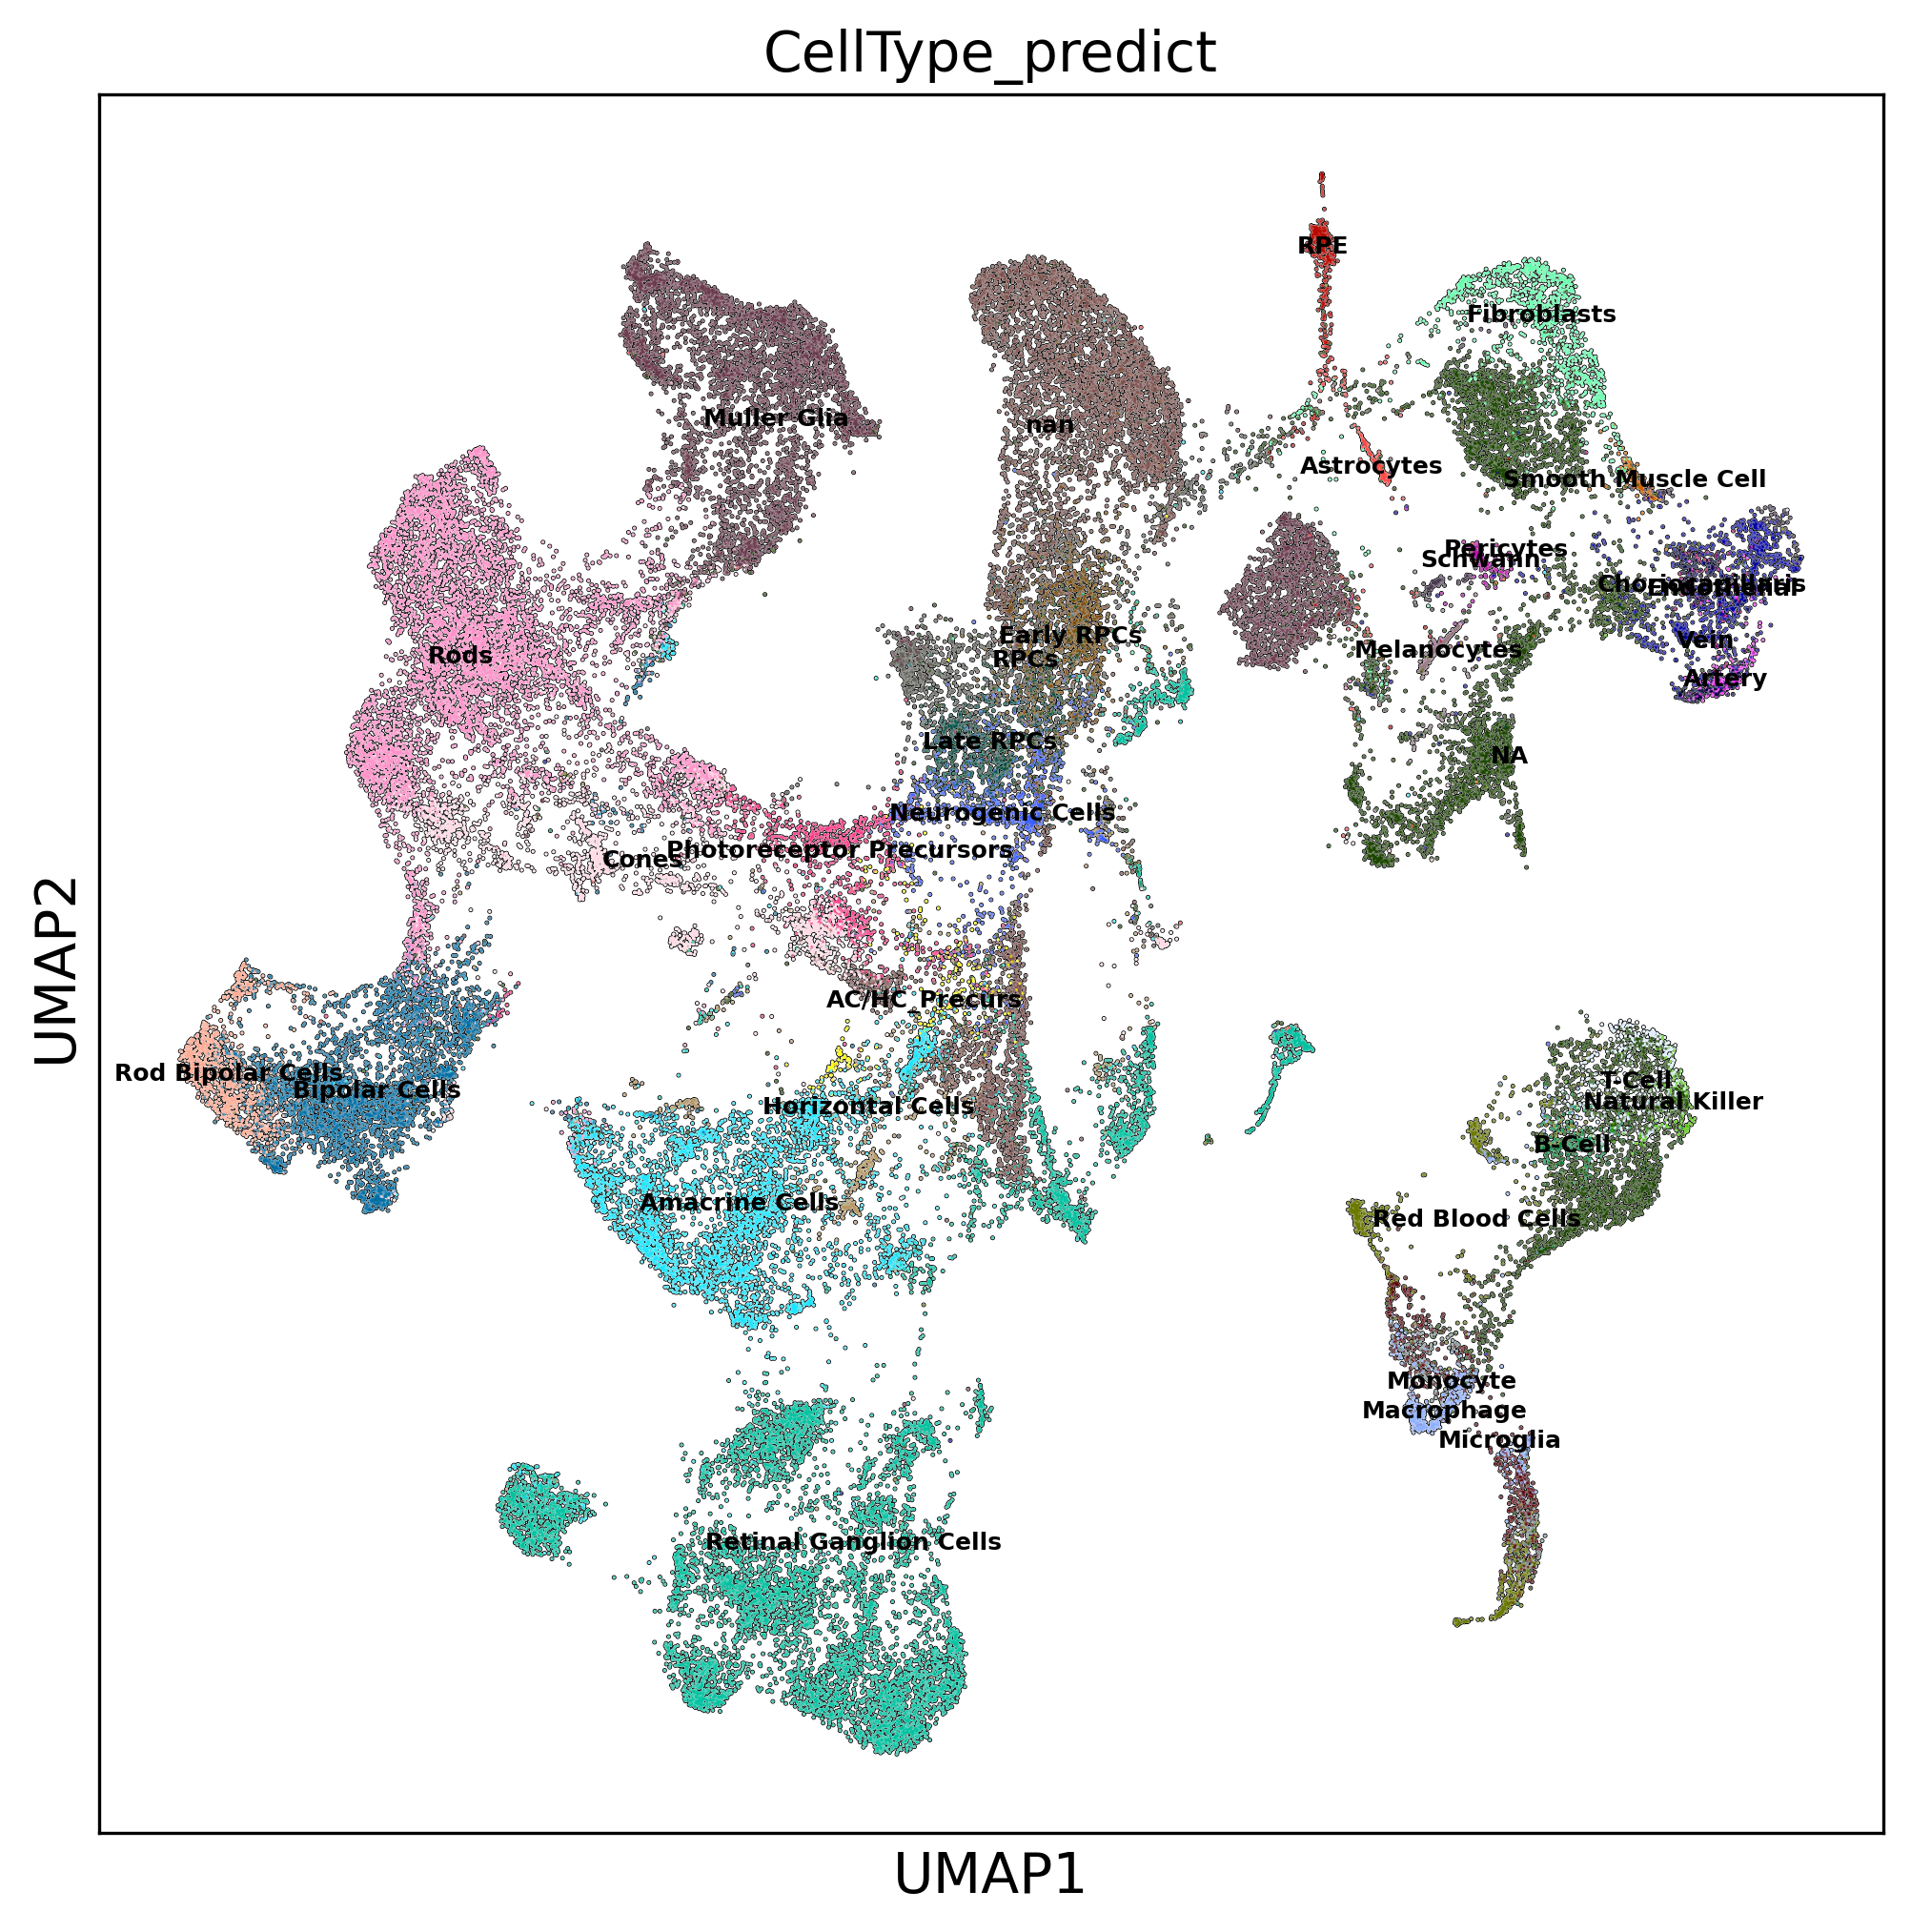

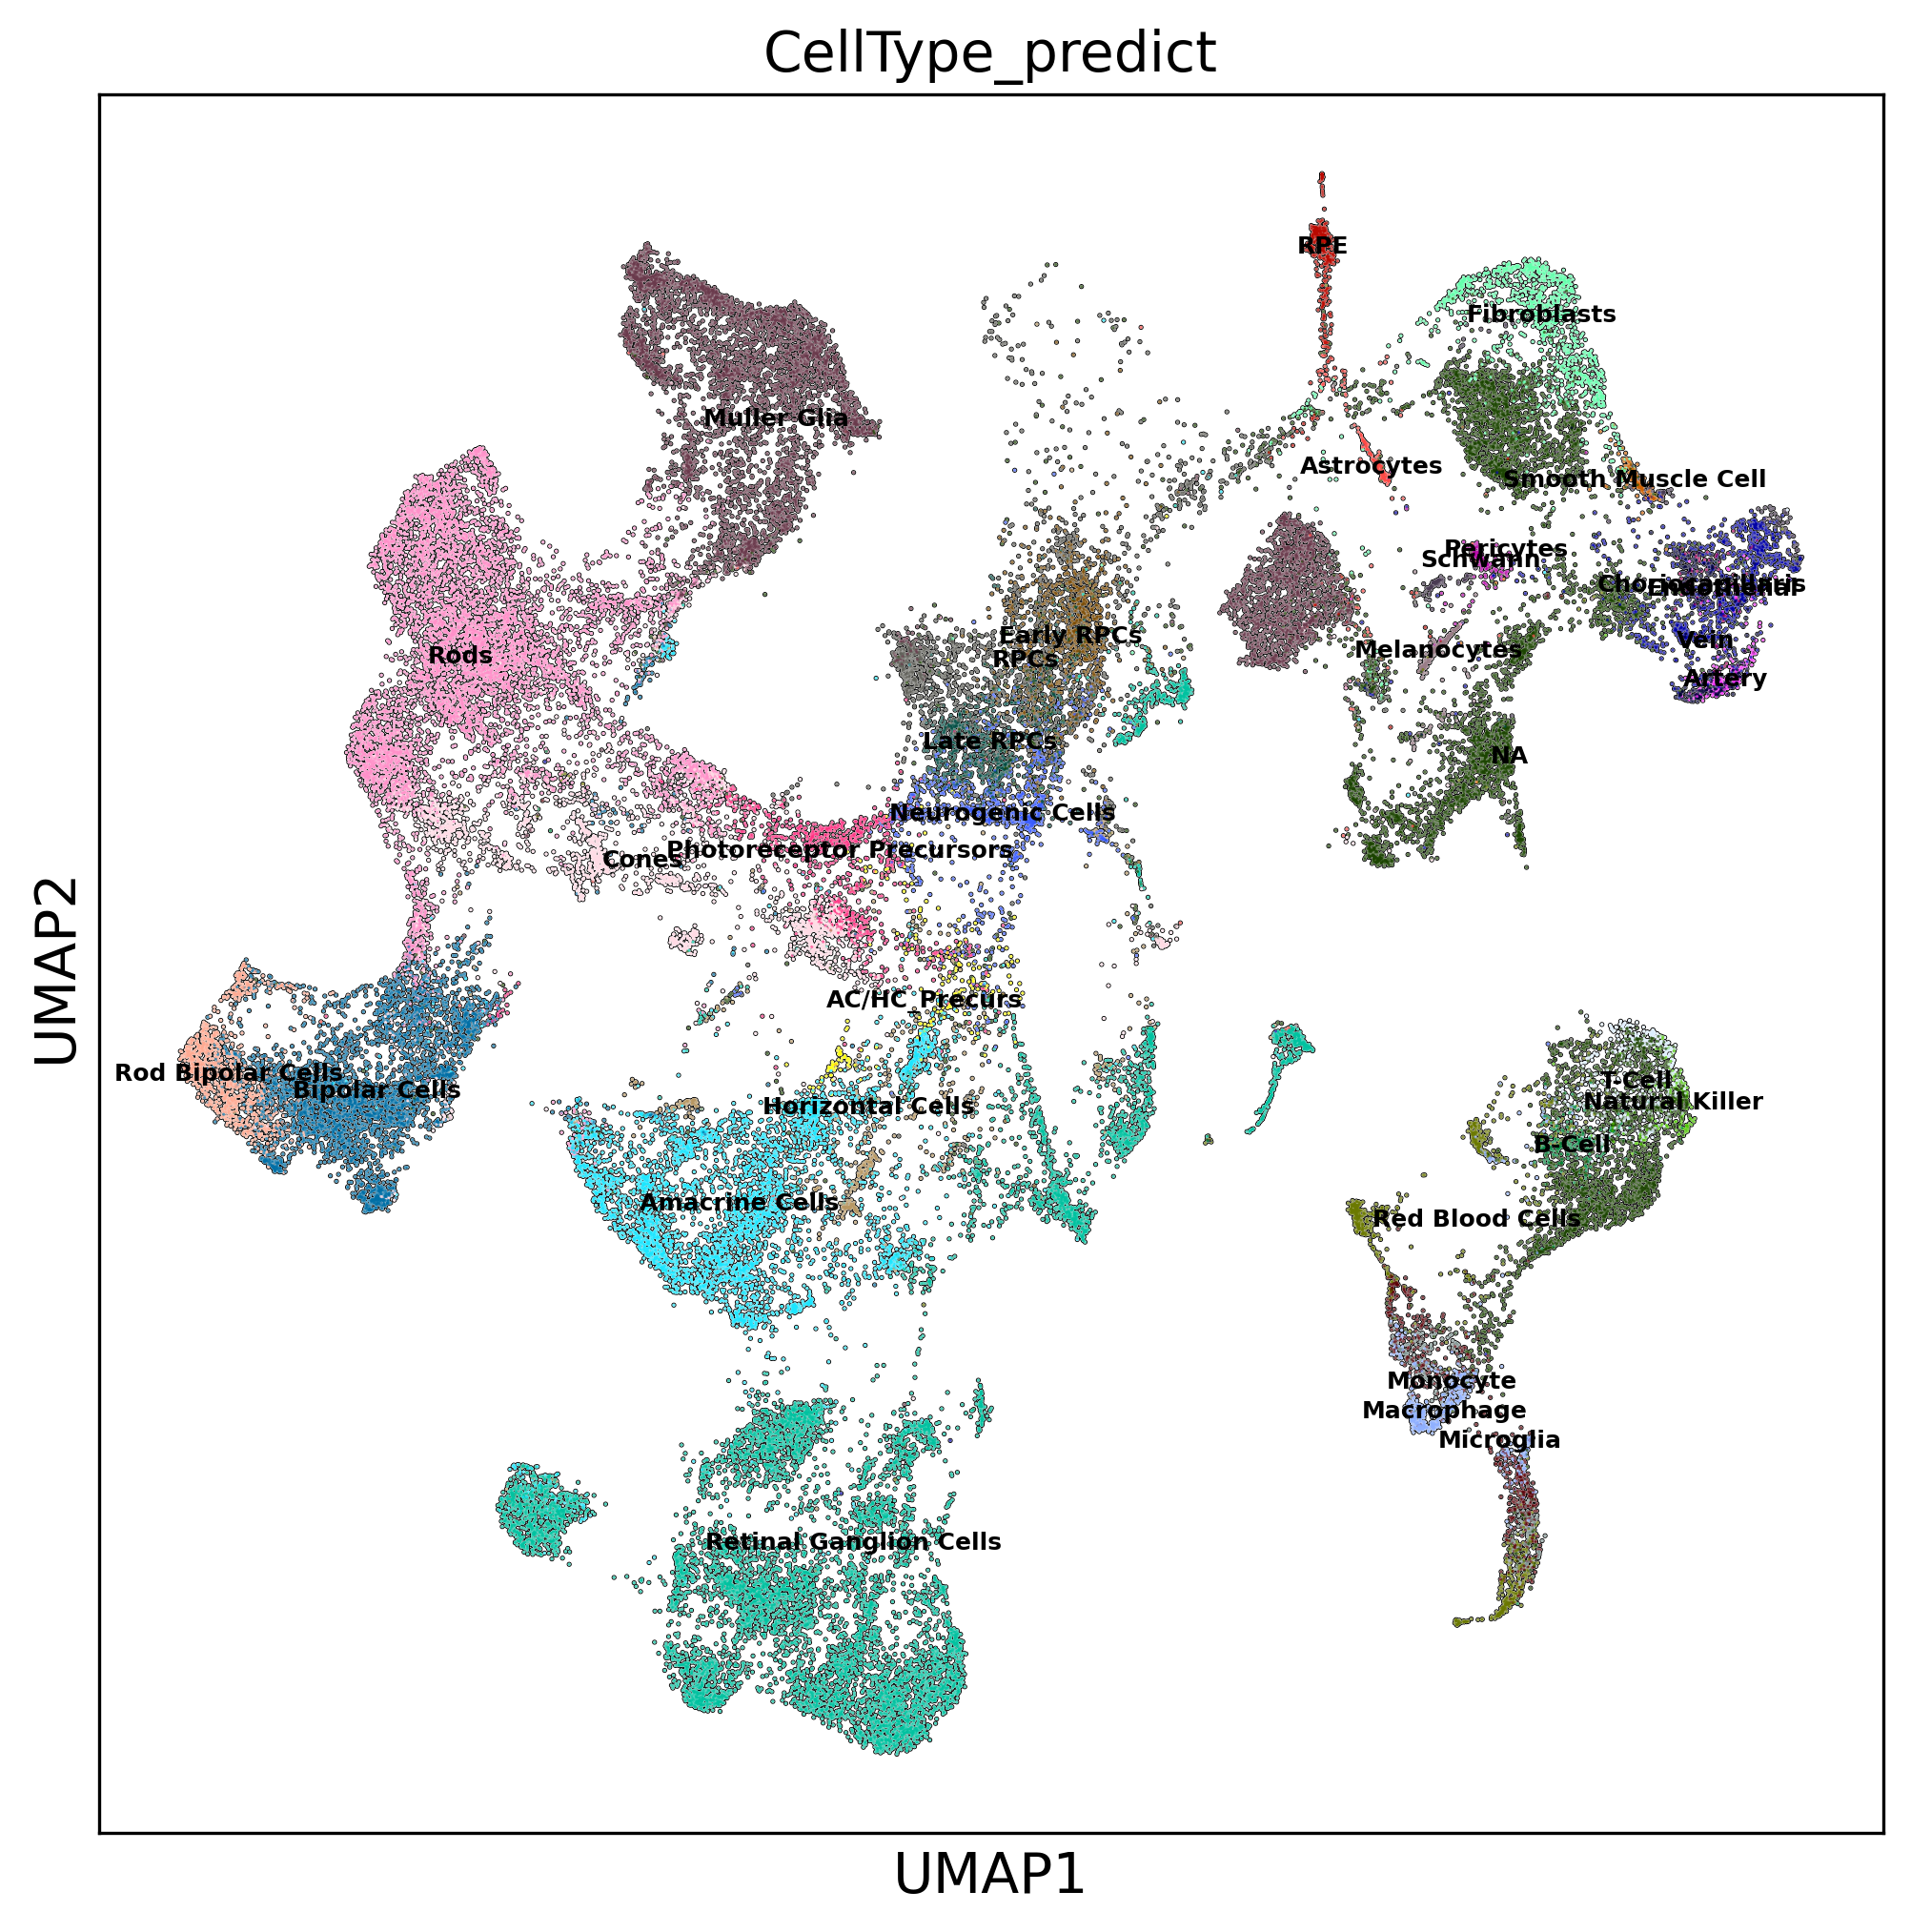

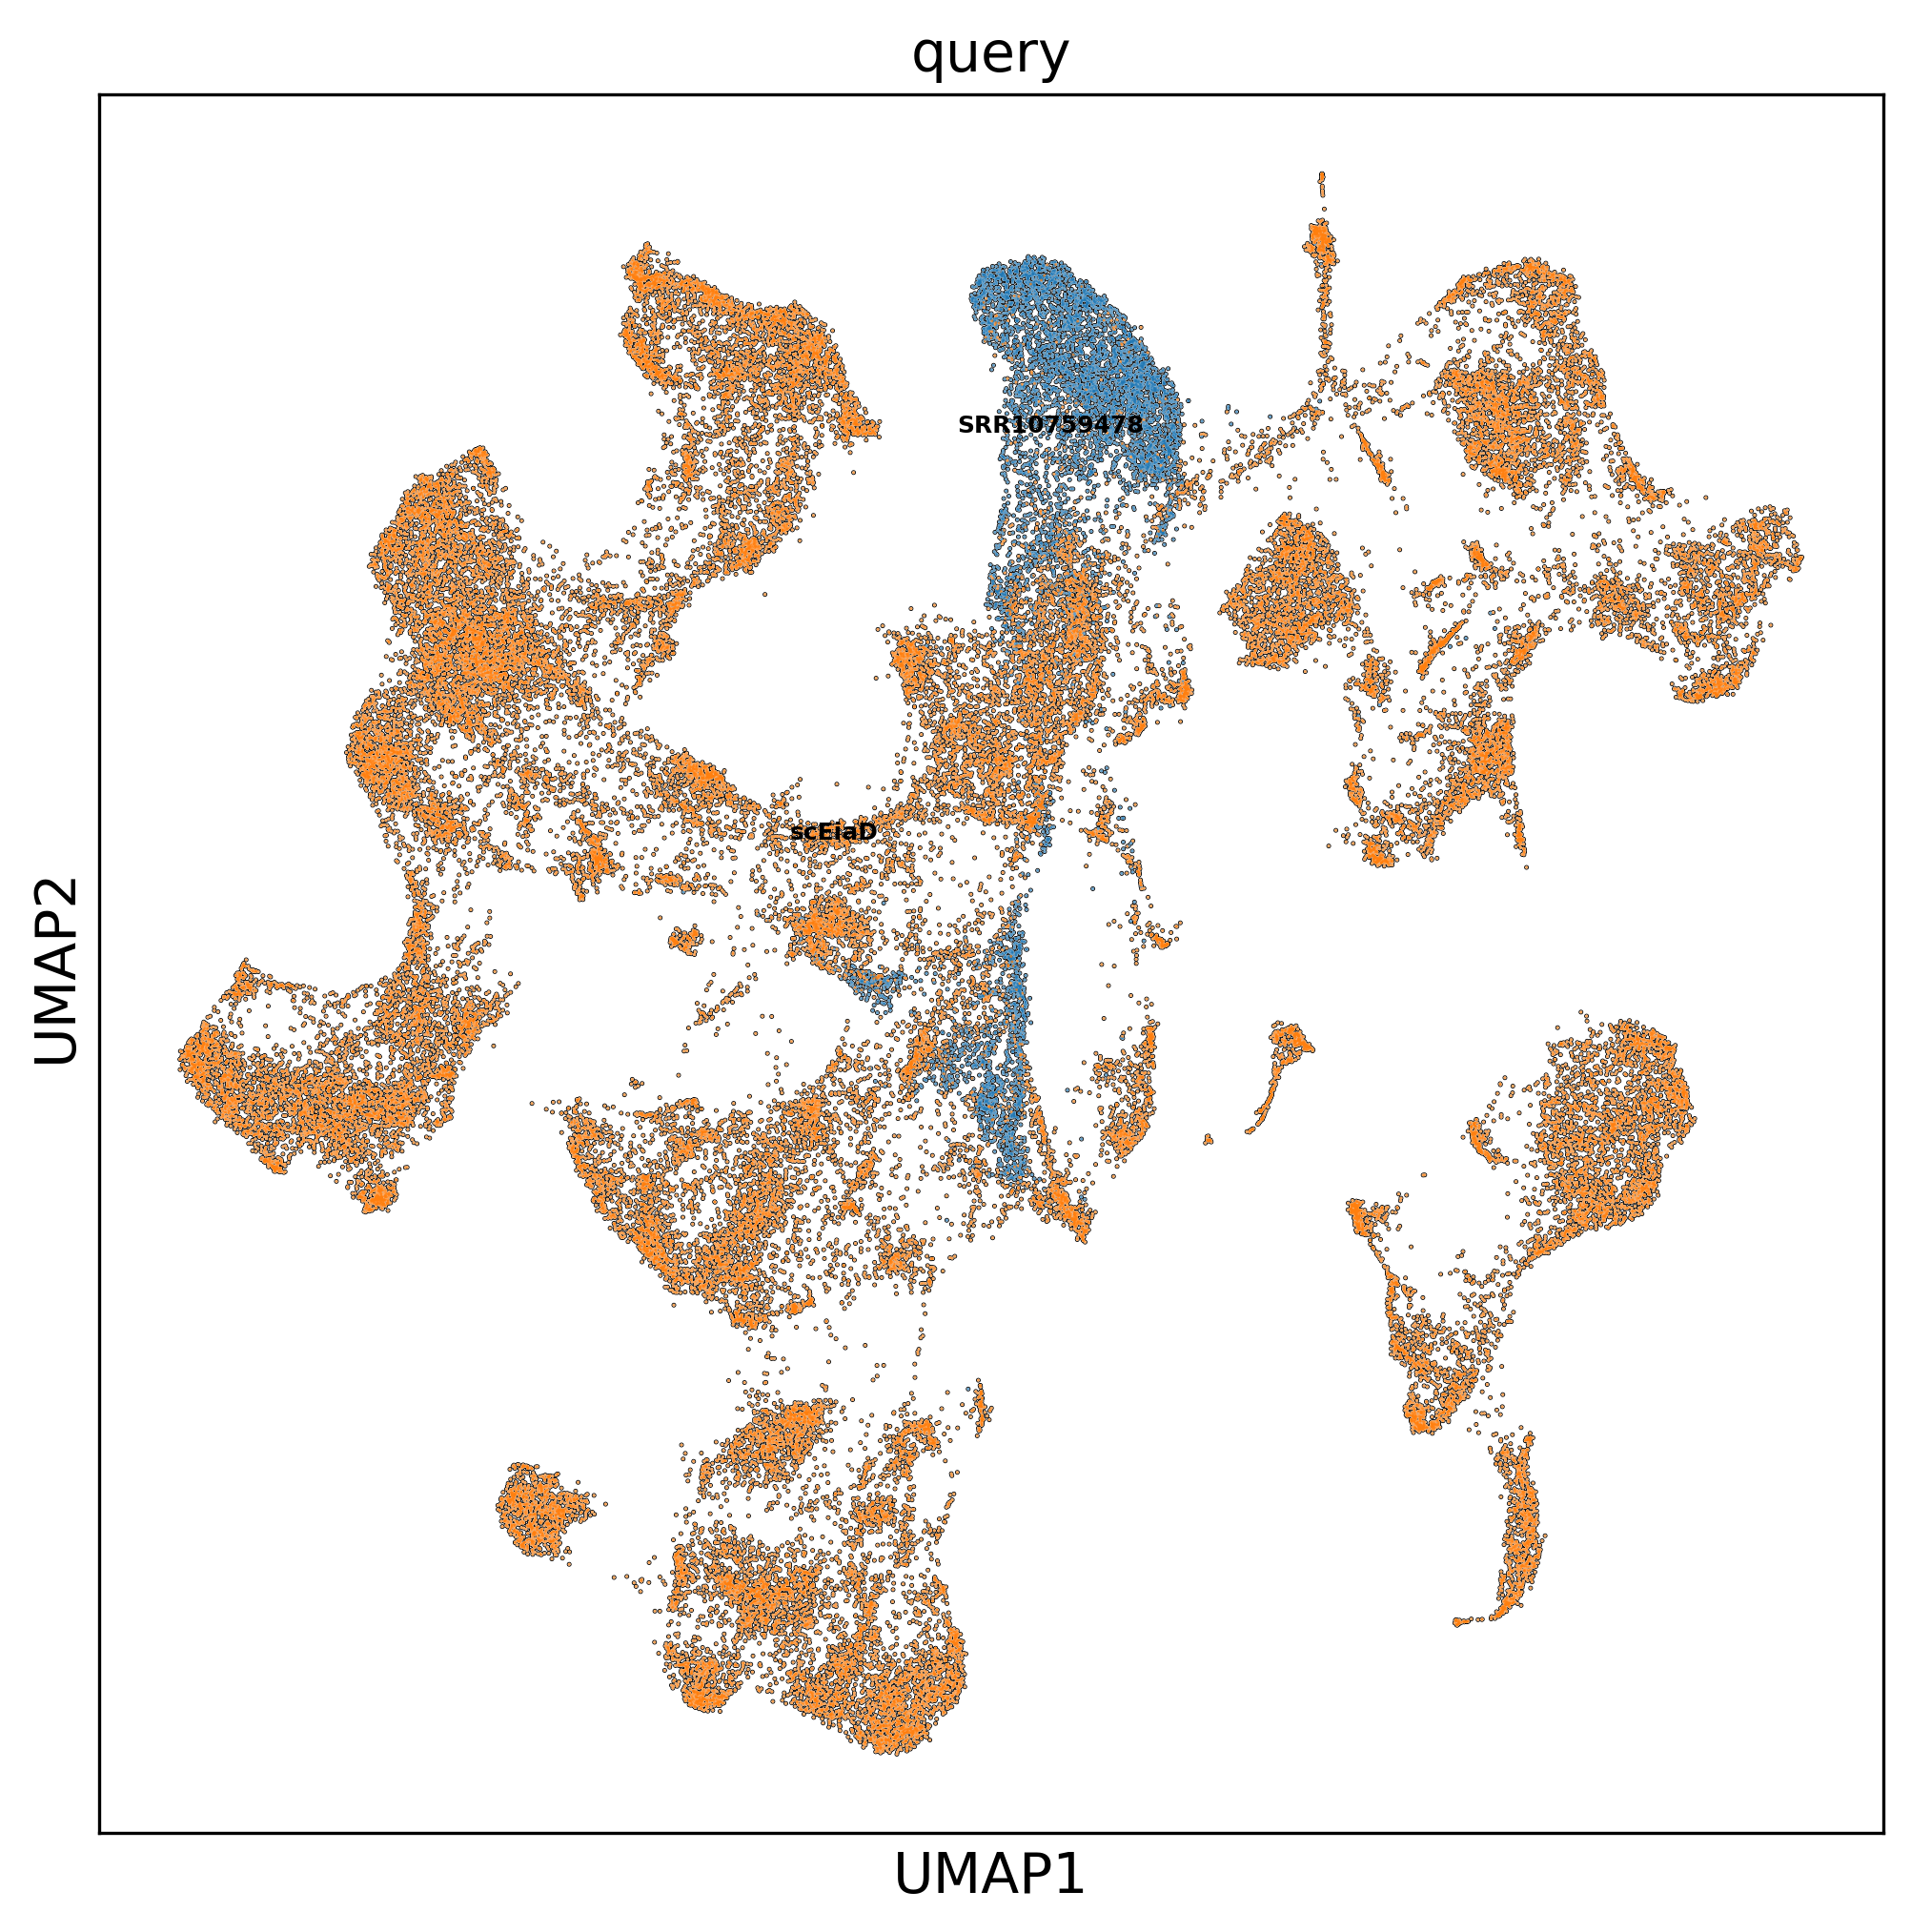

In [64]:
from matplotlib import rcParams
sc.set_figure_params(dpi=150)
rcParams['figure.figsize'] = 8, 8
sc.pl.umap(adata_full, color = 'CellType_predict', add_outline=True, legend_loc='on data',  legend_fontsize=6)
sc.pl.umap(adata_full[adata_full.obs['query'] == 'scEiaD'], color = 'CellType_predict', add_outline=True, legend_loc='on data',  legend_fontsize=6)
sc.pl.umap(adata_full, color = 'query', add_outline=True, legend_loc='on data', legend_fontsize=6)

In [63]:
adata_full[adata_full.obs['query'] == 'scEiaD']

View of AnnData object with n_obs × n_vars = 55553 × 15114
    obs: 'scEiaD_batch', 'query', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'batch', 'study_accession', 'Age', 'TechType', 'SA', 'Barcode', 'UMAP_1', 'UMAP_2', 'S.Score', 'G2M.Score', 'Phase', 'cluster', 'subcluster', 'sample_accession', 'library_layout', 'organism', 'Platform', 'UMI', 'Tissue', 'Covariate', 'integration_group', 'TissueNote', 'CellType', 'Paper', 'SubCellType', 'sample', 'barcode', 'donor', 'region', 'TabulaMurisCellType', 'Doublet.Probability', 'Doublet', 'doublet_score_scran', 'CellType_predict', 'TabulaMurisCellType_predict', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'leiden'
    var: 'gene_name-0', 'vst.mean-1', 'vst.variance-1', 'vst.variance.expected-1', 'vst.variance.standardized-1', 'vst.variable-1'
    uns: '_scvi', 'neighbors', 'umap', 'leiden', 'CellType_predict_colors', 'query_colors'
    obsm: 'X_scvi', 'X_umap'
    obsp: 'distances', 'connectivities'

In [14]:
adata_full.obs['batch']

AAACCTGAGAGCCCAA-0                            SRR10759478
AAACCTGAGAGTAATC-0                            SRR10759478
AAACCTGAGAGTACAT-0                            SRR10759478
AAACCTGAGCGATGAC-0                            SRR10759478
AAACCTGAGTTAACGA-0                            SRR10759478
                                           ...           
ATGTCCCAGCCGTTAT_SRS6517611-1    SRP257883_10xv3_donor_25
CCTGTTGAGCATGAAT_SRS6517611-1    SRP257883_10xv3_donor_25
TTCTTGATCCCTTGGT_SRS6517611-1    SRP257883_10xv3_donor_25
GTTTGGAAGATGACAT_SRS6517611-1    SRP257883_10xv3_donor_25
CATACAGAGTCGCCAC_SRS6517611-1    SRP257883_10xv3_donor_25
Name: batch, Length: 61751, dtype: object

In [ ]:
sc.pp.neighbors(adata_scEiaD, n_neighbors=50, use_rep = 'X_scvi')
sc.tl.umap(adata_scEiaD, min_dist=0.2)
#sc.pl.umap(adata_scEiaD, color = 'CellType_predict')

In [2]:
sc.pl.umap(adata_scEiaD, color = 'CellType_predict')

NameError: ignored

## Loading and preparing data

Let us first load the CORTEX dataset described in Zeisel et al. (2015). scvi-tools has many "built-in" datasets as well as support for loading arbitrary `.csv`, `.loom`, and `.h5ad` (AnnData) files. Please see our tutorial on [data loading](data_loading.ipynb) for more examples.

* Zeisel, Amit, et al. "Cell types in the mouse cortex and hippocampus revealed by single-cell RNA-seq." Science 347.6226 (2015): 1138-1142. 

<div class="alert alert-info">
Important

All scvi-tools models require AnnData objects as input. 

</div>

In [ ]:
adata = scvi.data.cortex(run_setup_anndata=False)

INFO      File /content/data/expression.bin already downloaded                  
INFO      Loading Cortex data from /content/data/expression.bin                 
INFO      Finished loading Cortex data                                          


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Now we preprocess the data to remove, for example, genes that are very lowly expressed and other outliers. For these tasks we prefer the [Scanpy preprocessing module](https://scanpy.readthedocs.io/en/stable/api/index.html#module-scanpy.pp).

In [ ]:
sc.pp.filter_genes(adata, min_counts=3)

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In scRNA-seq analysis, among others, it's popular to normalize the data. These values are not used by scvi-tools, but given their popularity in other tasks as well as for visualization, we store them in the anndata object separately (via the `.raw` attribute).

<div class="alert alert-info">

Important

Unless otherwise specific, scvi-tools models require the raw counts.

</div>

In [ ]:
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`

Finally, we perform feature selection, to reduce the number of features (genes in this case) used as input to the scvi-tools model. For best practices of how/when to perform feature selection, please refer to the model-specific tutorial.

In [ ]:
sc.pp.highly_variable_genes(
    adata, 
    n_top_genes=2000, 
    subset=True, 
    layer="counts", 
    flavor="seurat_v3"
)

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/usr/local/lib/python3.6/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


Now it's time to run `setup_anndata()`, which alerts scvi-tools to the locations of various matrices inside the anndata. It's important to run this function with the correct arguments so scvi-tools is notified that your dataset has batches, annotations, etc. For example, if batches are registered with scvi-tools, the subsequent model will correct for batch effects. See the full documentation for details.



In [ ]:
scvi.data.setup_anndata(adata, layer="counts")

INFO      No batch_key inputted, assuming all cells are same batch              
INFO      No label_key inputted, assuming all cells have same label             
INFO      Using data from adata.layers["counts"]                                
INFO      Computing library size prior per batch                                
INFO      Successfully registered anndata object containing 3005 cells, 2000    
          vars, 1 batches, 1 labels, and 0 proteins. Also registered 0 extra    
          categorical covariates and 0 extra continuous covariates.             
INFO      Please do not further modify adata until model is trained.            


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


<div class="alert alert-warning">

Warning

If the adata is modified after running `setup_anndata`, please run `setup_anndata` again.

</div>

## Creating and training a model

While we highlight the scVI model here, the API is consistent across all scvi-tools models and is inspired by that of [scikit-learn](https://scikit-learn.org/stable/). For a full list of options, see the scvi [documentation](https://scvi-tools.org).

In [ ]:
model = scvi.model.SCVI(adata)

We can see an overview of the model by printing it.

In [ ]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Not Trained


To print summary of associated AnnData, use: 
scvi.data.view_anndata_setup(model.adata)


In [ ]:
model.train()

INFO      Training for 400 epochs                                               
INFO      KL warmup for 400 epochs                                              
Training...: 100%|██████████| 400/400 [01:35<00:00,  4.18it/s]
INFO      Training time:  95 s. / 400 epochs                                    


### Saving and loading

Saving consists of saving the model neural network weights, as well as parameters used to initialize the model.

In [ ]:
model.save("my_model/")

In [ ]:
model = scvi.model.SCVI.load("my_model/", adata, use_cuda=True)

INFO      Using data from adata.layers["counts"]                                
INFO      Computing library size prior per batch                                
INFO      Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 
          'labels']                                                             
INFO      Successfully registered anndata object containing 3005 cells, 2000    
          vars, 1 batches, 1 labels, and 0 proteins. Also registered 0 extra    
          categorical covariates and 0 extra continuous covariates.             


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


## Obtaining model outputs

In [ ]:
latent = model.get_latent_representation()

It's often useful to store the outputs of scvi-tools back into the original anndata, as it permits interoperability with Scanpy.

In [ ]:
adata.obsm["X_scVI"] = latent

The `model.get...()` functions default to using the anndata that was used to initialize the model. It's possible to also query a subset of the anndata, or even use a completely independent anndata object as long as the anndata is organized in an equivalent fashion.

In [ ]:
adata_subset = adata[adata.obs.cell_type == "interneurons"]
latent_subset = model.get_latent_representation(adata_subset)

INFO      Received view of anndata, making copy.                                


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [ ]:
denoised = model.get_normalized_expression(adata_subset, library_size=10e4)
denoised.iloc[:5, :5]

INFO      Received view of anndata, making copy.                                


Tshz1  2310042E22Rik      Sema3c       Jam2      Klhl13
0  34.172291      11.900369  226.214600  36.507690  103.343269
1  31.713140      28.055269  204.428802  13.279721  106.054047
2  18.533686      31.503839  612.331909  78.135330  202.348083
3  25.587479      51.464203  241.749634  18.102861  148.764862
4  68.990685      26.903820  157.888565  10.193274  138.968933

Let's store the normalized values back in the anndata.

In [ ]:
adata.layers["scvi_normalized"] = model.get_normalized_expression(
    library_size=10e4
)

## Interoperability with Scanpy

Scanpy is a powerful python library for visualization and downstream analysis of scRNA-seq data. We show here how to feed the objects produced by scvi-tools into a scanpy workflow.

In [ ]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.2)

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'precise_labels' as categorical
... storing 'cell_type' as categorical


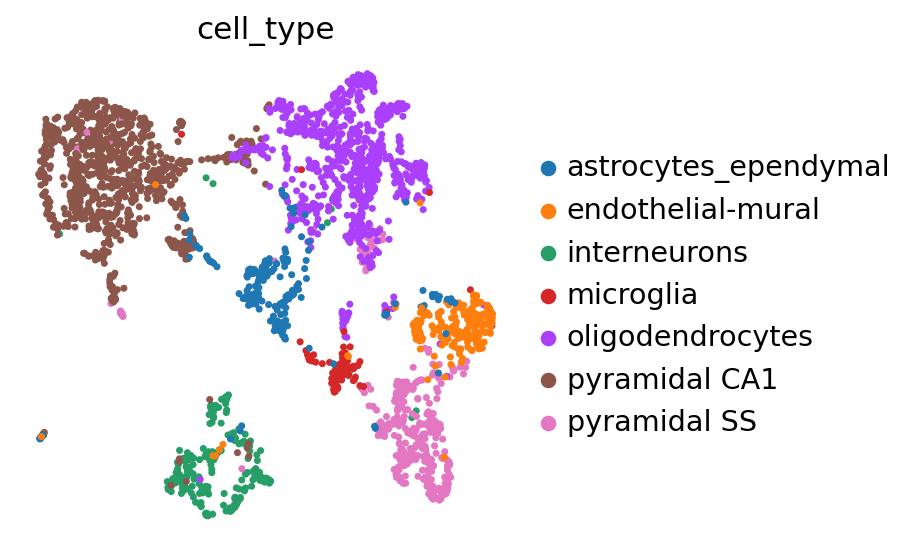

In [ ]:
sc.pl.umap(
    adata, 
    color="cell_type", 
    frameon=False,
)

The user will note that we imported curated labels from the original publication. Our interface with scanpy makes it easy to cluster the data with scanpy from scVI's latent space and then reinject them into scVI (e.g., for differential expression).

In [ ]:
# neighbors were already computed using scVI
sc.tl.leiden(adata, key_added="leiden_scVI")

## Differential expression
We can also use many scvi-tools models for differential expression. For further details on the methods underlying these functions as well as additional options, please see TODO.

In [ ]:
adata.obs.cell_type.head()

0    interneurons
1    interneurons
2    interneurons
3    interneurons
4    interneurons
Name: cell_type, dtype: category
Categories (7, object): ['astrocytes_ependymal', 'endothelial-mural', 'interneurons', 'microglia',
                         'oligodendrocytes', 'pyramidal CA1', 'pyramidal SS']

For example, a 1-vs-1 DE test is as simple as:

In [ ]:
de_df = model.differential_expression(
    groupby="cell_type", 
    group1="oligodendrocytes", 
    group2="pyramidal CA1"
)
de_df.head()

DE...: 100%|██████████| 1/1 [00:04<00:00,  4.15s/it]


proba_de  ...                         comparison
Icam5     1.0000  ...  oligodendrocytes vs pyramidal CA1
Mmd       1.0000  ...  oligodendrocytes vs pyramidal CA1
Slc8a1    0.9998  ...  oligodendrocytes vs pyramidal CA1
Dgkg      0.9998  ...  oligodendrocytes vs pyramidal CA1
Ddn       0.9998  ...  oligodendrocytes vs pyramidal CA1

[5 rows x 18 columns]

We can also do a 1-vs-all DE test, which compares each cell type with the rest of the dataset:

In [ ]:
de_df = model.differential_expression(
    groupby="cell_type", 
)
de_df.head()

DE...: 100%|██████████| 7/7 [00:29<00:00,  4.28s/it]


proba_de  proba_not_de  ...  is_de_fdr_0.05                    comparison
Cml5      0.9948        0.0052  ...            True  astrocytes_ependymal vs Rest
Slc1a3    0.9942        0.0058  ...            True  astrocytes_ependymal vs Rest
Gja1      0.9926        0.0074  ...            True  astrocytes_ependymal vs Rest
Aqp4      0.9924        0.0076  ...            True  astrocytes_ependymal vs Rest
Obox6     0.9912        0.0088  ...            True  astrocytes_ependymal vs Rest

[5 rows x 18 columns]

We now extract top markers for each cluster using the DE results.

In [ ]:
markers = {}
cats = adata.obs.cell_type.cat.categories
for i, c in enumerate(cats):
    cid = "{} vs Rest".format(c)
    cell_type_df = de_df.loc[de_df.comparison == cid]
    cell_type_df = cell_type_df.sort_values("lfc_mean", ascending=False)

    cell_type_df = cell_type_df[cell_type_df.lfc_mean > 0]

    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 3]
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1]

    markers[c] = cell_type_df.index.tolist()[:3]

In [ ]:
sc.tl.dendrogram(adata, groupby="cell_type", use_rep="X_scVI")

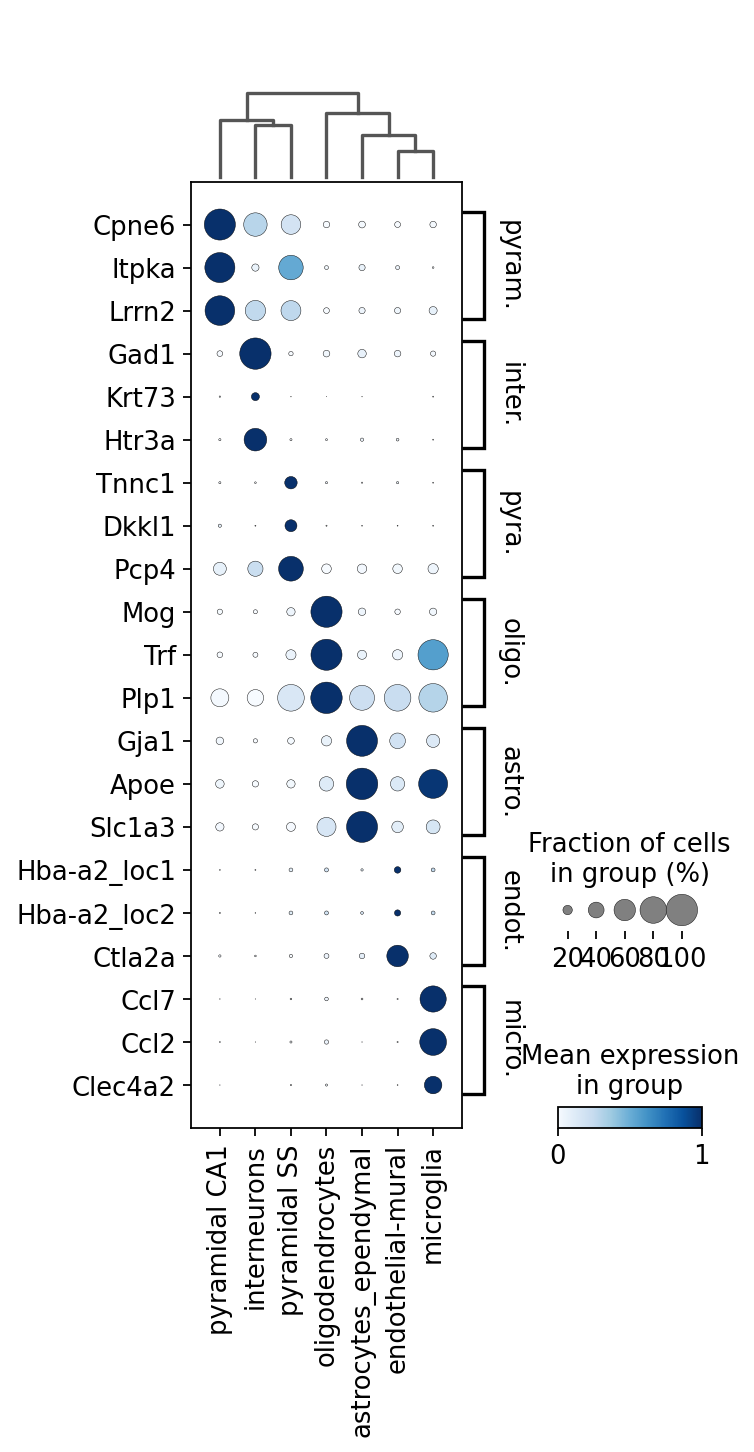

In [ ]:
sc.pl.dotplot(
    adata, 
    markers, 
    groupby='cell_type', 
    dendrogram=True, 
    color_map="Blues",
    swap_axes=True,
    use_raw=True,
    standard_scale="var",
)

We can also visualize the scVI normalized gene expression values with the `layer` option.

         Falling back to preprocessing with `sc.pp.pca` and default params.


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


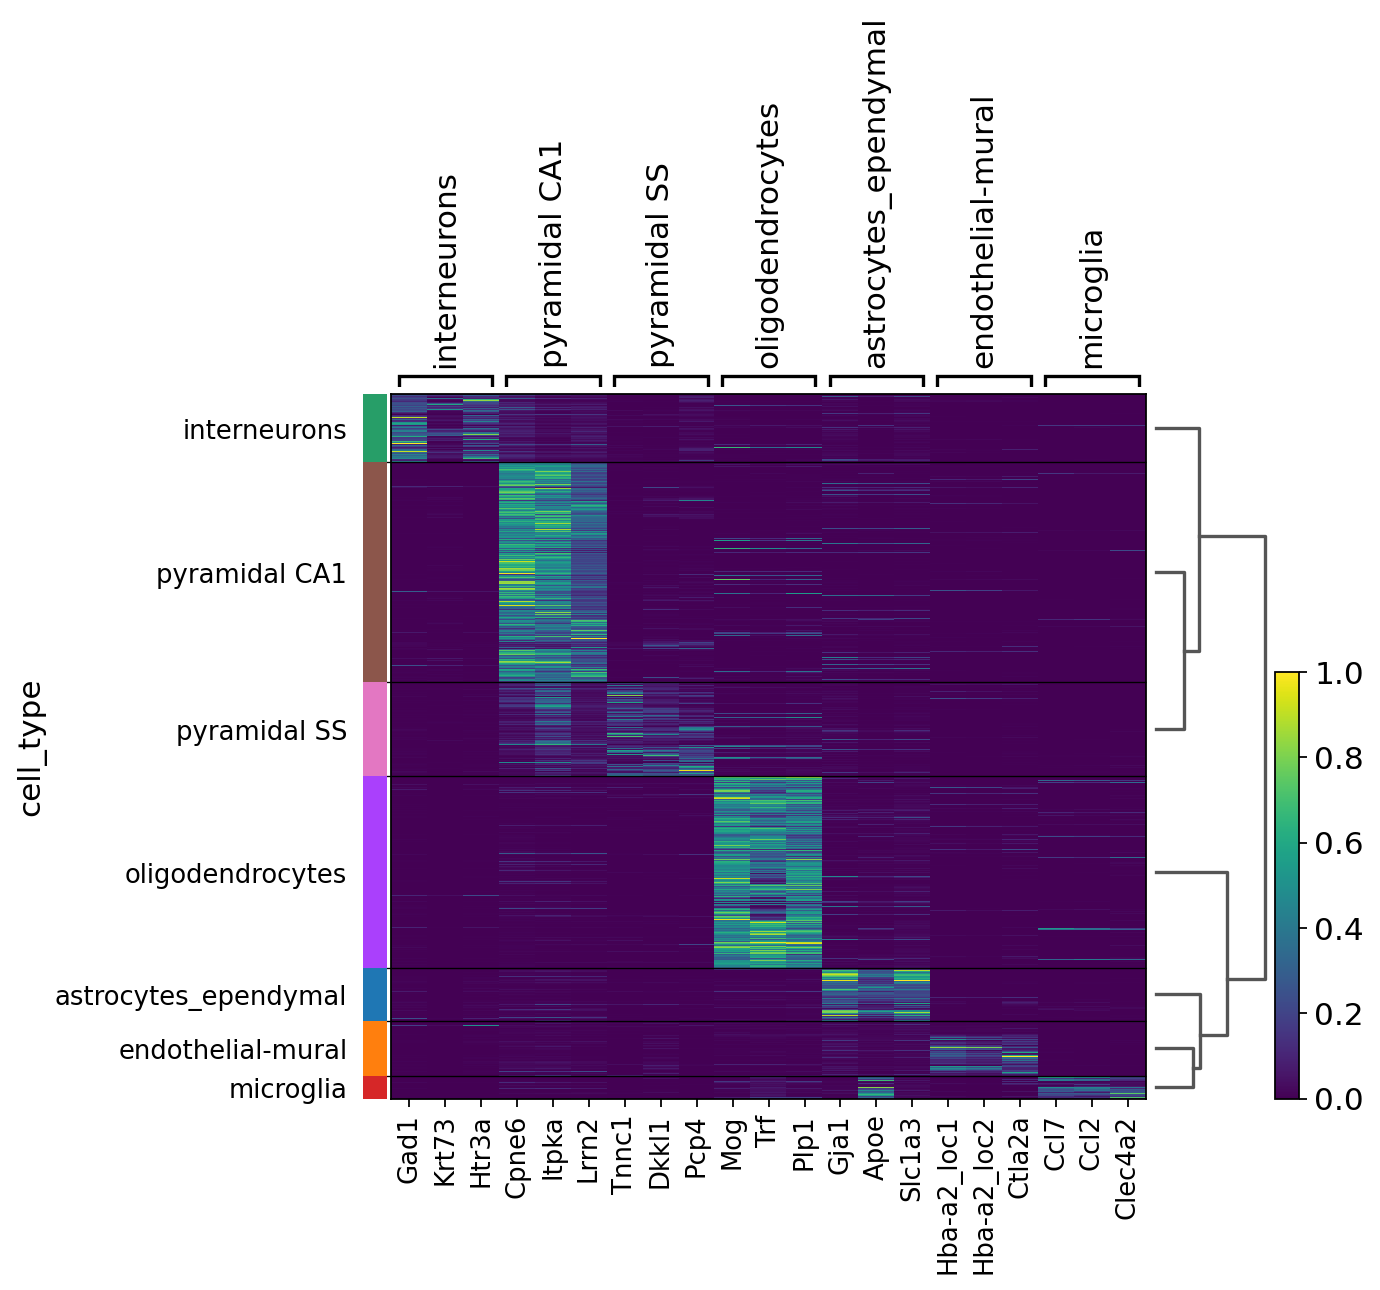

In [ ]:
sc.pl.heatmap(
    adata, 
    markers, 
    groupby='cell_type', 
    layer="scvi_normalized",
    standard_scale="var",
    dendrogram=True,
)

## Logging information

Verbosity varies in the following way:

* `logger.setLevel(logging.WARNING)` will show a progress bar.
* `logger.setLevel(logging.INFO)` will show global logs including the number of jobs done.
* `logger.setLevel(logging.DEBUG)` will show detailed logs for each training (e.g the parameters tested).

This function's behaviour can be customized, please refer to its documentation for information about the different parameters available.

In general, you can use `scvi.settings.verbosity` to set the verbosity of the scvi package.
Note that `verbosity` corresponds to the logging levels of the standard python `logging` module. By default, that verbosity level is set to `INFO` (=20).
As a reminder the logging levels are:

<table class="docutils align-center">
<colgroup>
<col style="width: 48%">
<col style="width: 52%">
</colgroup>
<thead>
<tr class="row-odd"><th class="head"><p>Level</p></th>
<th class="head"><p>Numeric value</p></th>
</tr>
</thead>
<tbody>
<tr class="row-even"><td><p><code class="docutils literal notranslate"><span class="pre">CRITICAL</span></code></p></td>
<td><p>50</p></td>
</tr>
<tr class="row-odd"><td><p><code class="docutils literal notranslate"><span class="pre">ERROR</span></code></p></td>
<td><p>40</p></td>
</tr>
<tr class="row-even"><td><p><code class="docutils literal notranslate"><span class="pre">WARNING</span></code></p></td>
<td><p>30</p></td>
</tr>
<tr class="row-odd"><td><p><code class="docutils literal notranslate"><span class="pre">INFO</span></code></p></td>
<td><p>20</p></td>
</tr>
<tr class="row-even"><td><p><code class="docutils literal notranslate"><span class="pre">DEBUG</span></code></p></td>
<td><p>10</p></td>
</tr>
<tr class="row-odd"><td><p><code class="docutils literal notranslate"><span class="pre">NOTSET</span></code></p></td>
<td><p>0</p></td>
</tr>
</tbody>
</table>